# Calculations for PV Global installs, c-Si Marketshare

This journal documents the manipulation of PV installation data for Global installs. This covers selection of data, and weighting by marketshare.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})
plt.rcParams['figure.figsize'] = (30, 15)

cwd = os.getcwd() #grabs current working directory

supportMatfolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')

In [2]:
cwd = os.getcwd() #grabs current working directory
df_installs_raw = pd.read_csv(os.path.join(supportMatfolder,'PVInstalls_World_AllSources.csv'), index_col='Year')
sources = df_installs_raw.columns
print(len(sources))

4


In [3]:
df_installs_raw

,IRENA online query tool (https://public.tableau.com/views/IRENARETimeSeries/Charts?:embed=y&:showVizHome=no&publish=yes&:toolbar=no),"IEA Member Country Report, 1995 (https://iea-pvps.org/wp-content/uploads/2020/01/tr_1995_01.pdf)",IEA PVPS Task 1 Market Snapshot Reports https://iea-pvps.org/snapshot-reports/,"A. Goetzberger, C. Hebling, and H.-W. Schock, “Photovoltaic materials, history, status and outlook,” Materials Science and Engineering: R: Reports, vol. 40, no. 1, pp. 1–46, Jan. 2003, doi: 10.1016/S0927-796X(02)00092-X."
Year,,,,
1990,NaN,NaN,NaN,NaN
1991,NaN,14.1,NaN,NaN
1992,NaN,24.9,NaN,57.9
1993,NaN,24.1,NaN,60.1
1994,NaN,27.0,NaN,69.4
...,...,...,...,...
2046,NaN,NaN,NaN,NaN
2047,NaN,NaN,NaN,NaN
2048,NaN,NaN,NaN,NaN


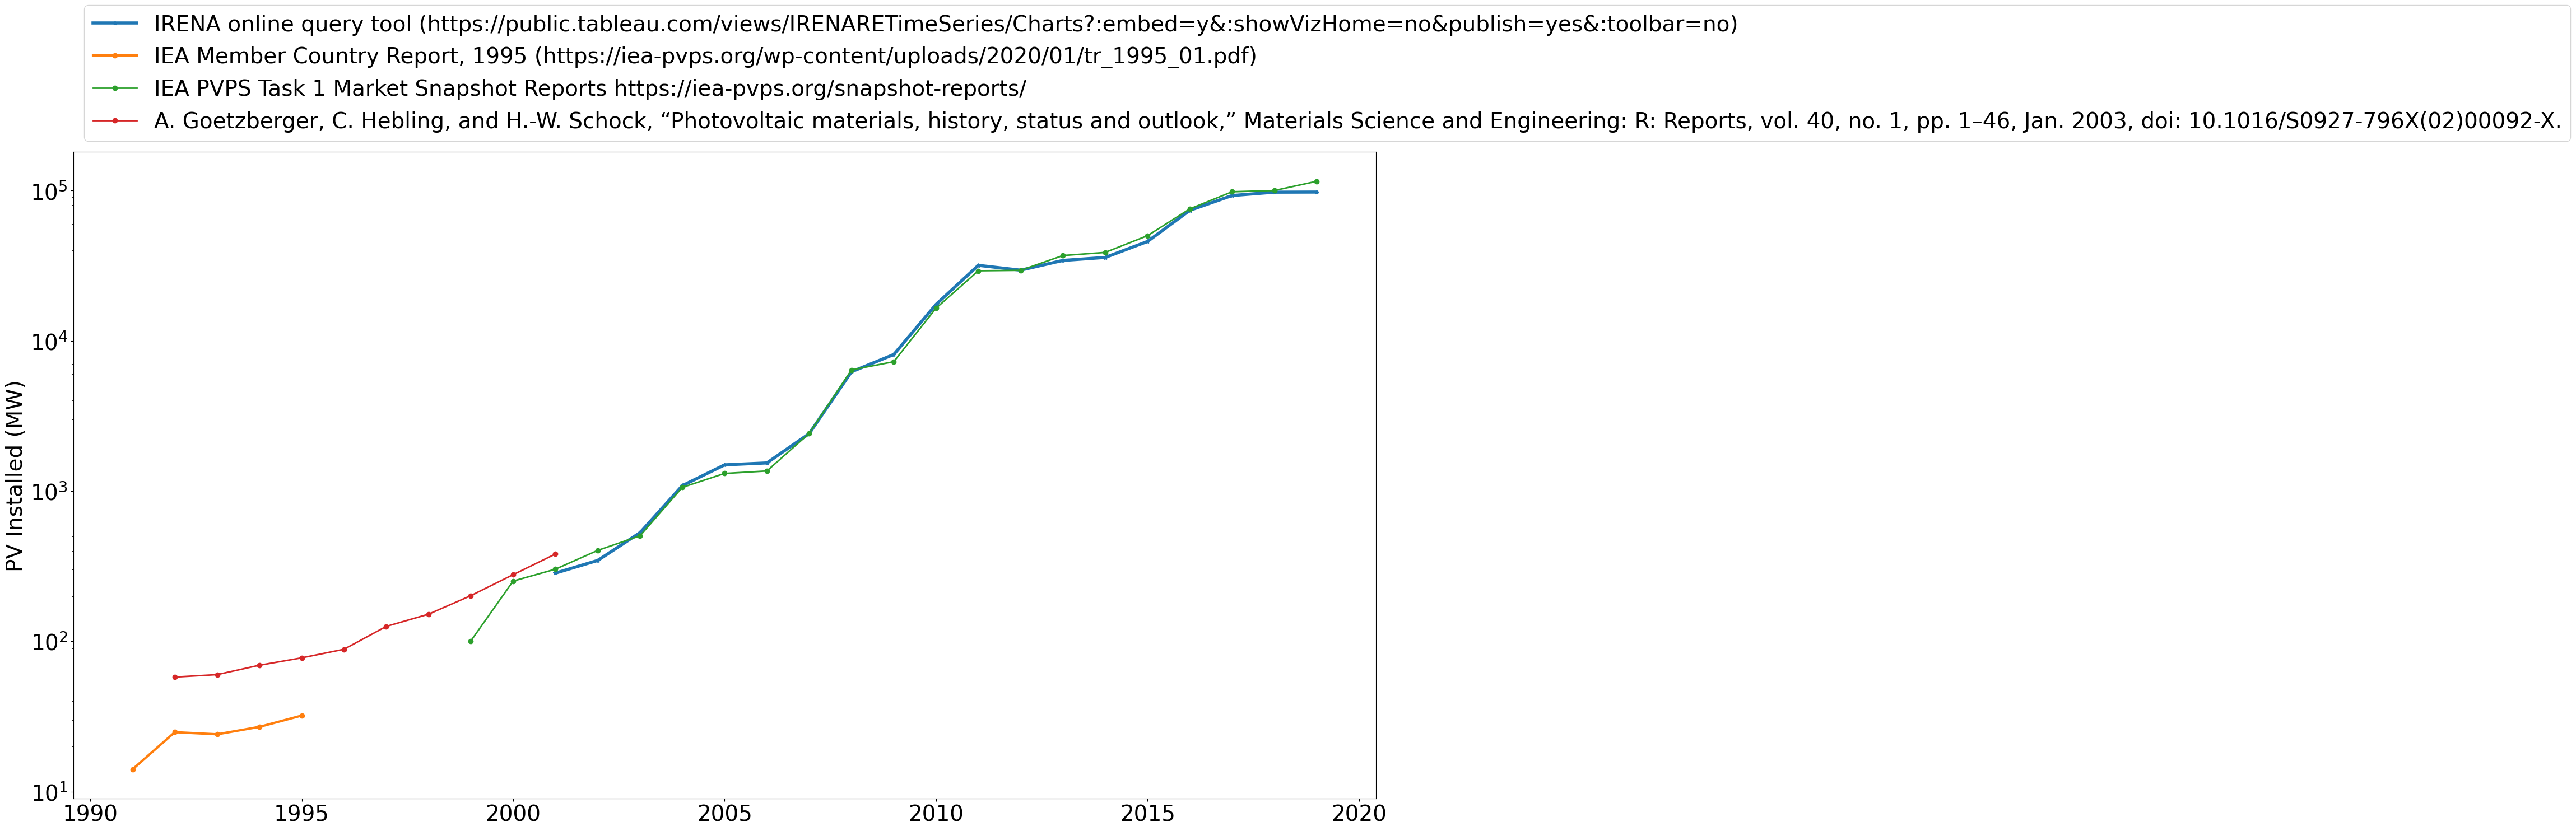

In [4]:
plt.plot(df_installs_raw.index,df_installs_raw[sources[0]],lw=4,marker='*',label=sources[0])
plt.plot(df_installs_raw.index,df_installs_raw[sources[1]],lw=3,marker='o',label=sources[1])
plt.plot(df_installs_raw.index,df_installs_raw[sources[2]],lw=2,marker='o',label=sources[2])
plt.plot(df_installs_raw.index,df_installs_raw[sources[3]],lw=2,marker='o',label=sources[3])

plt.yscale('log')
plt.ylabel('PV Installed (MW)')
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
#plt.plot(df_installs_raw, marker='o')

# Select the data to use for installs

Based on the above graph, we will utilize Goetzberger data through 2000, then IRENA online query tool after 2000.

In [5]:
#Before 2000 = Goetz
installs_old = df_installs_raw.loc[(df_installs_raw.index<=2000) & (df_installs_raw.index>=1995)]
installs_old_Goetz = pd.DataFrame(installs_old[sources[3]])
installs_old_Goetz.columns = ['installed_pv_MW']

#After 2000 = IRENA
installs_recent = df_installs_raw.loc[(df_installs_raw.index>2000) & (df_installs_raw.index<2020)]
installs_recent_IRENA = pd.DataFrame(installs_recent[sources[0]])
installs_recent_IRENA.columns = ['installed_pv_MW']
#print(installs_recent_IRENA)

### Collect the installation data together into a single df

Text(0.5, 1.0, 'Installations of PV Globally (MW) since 1995')

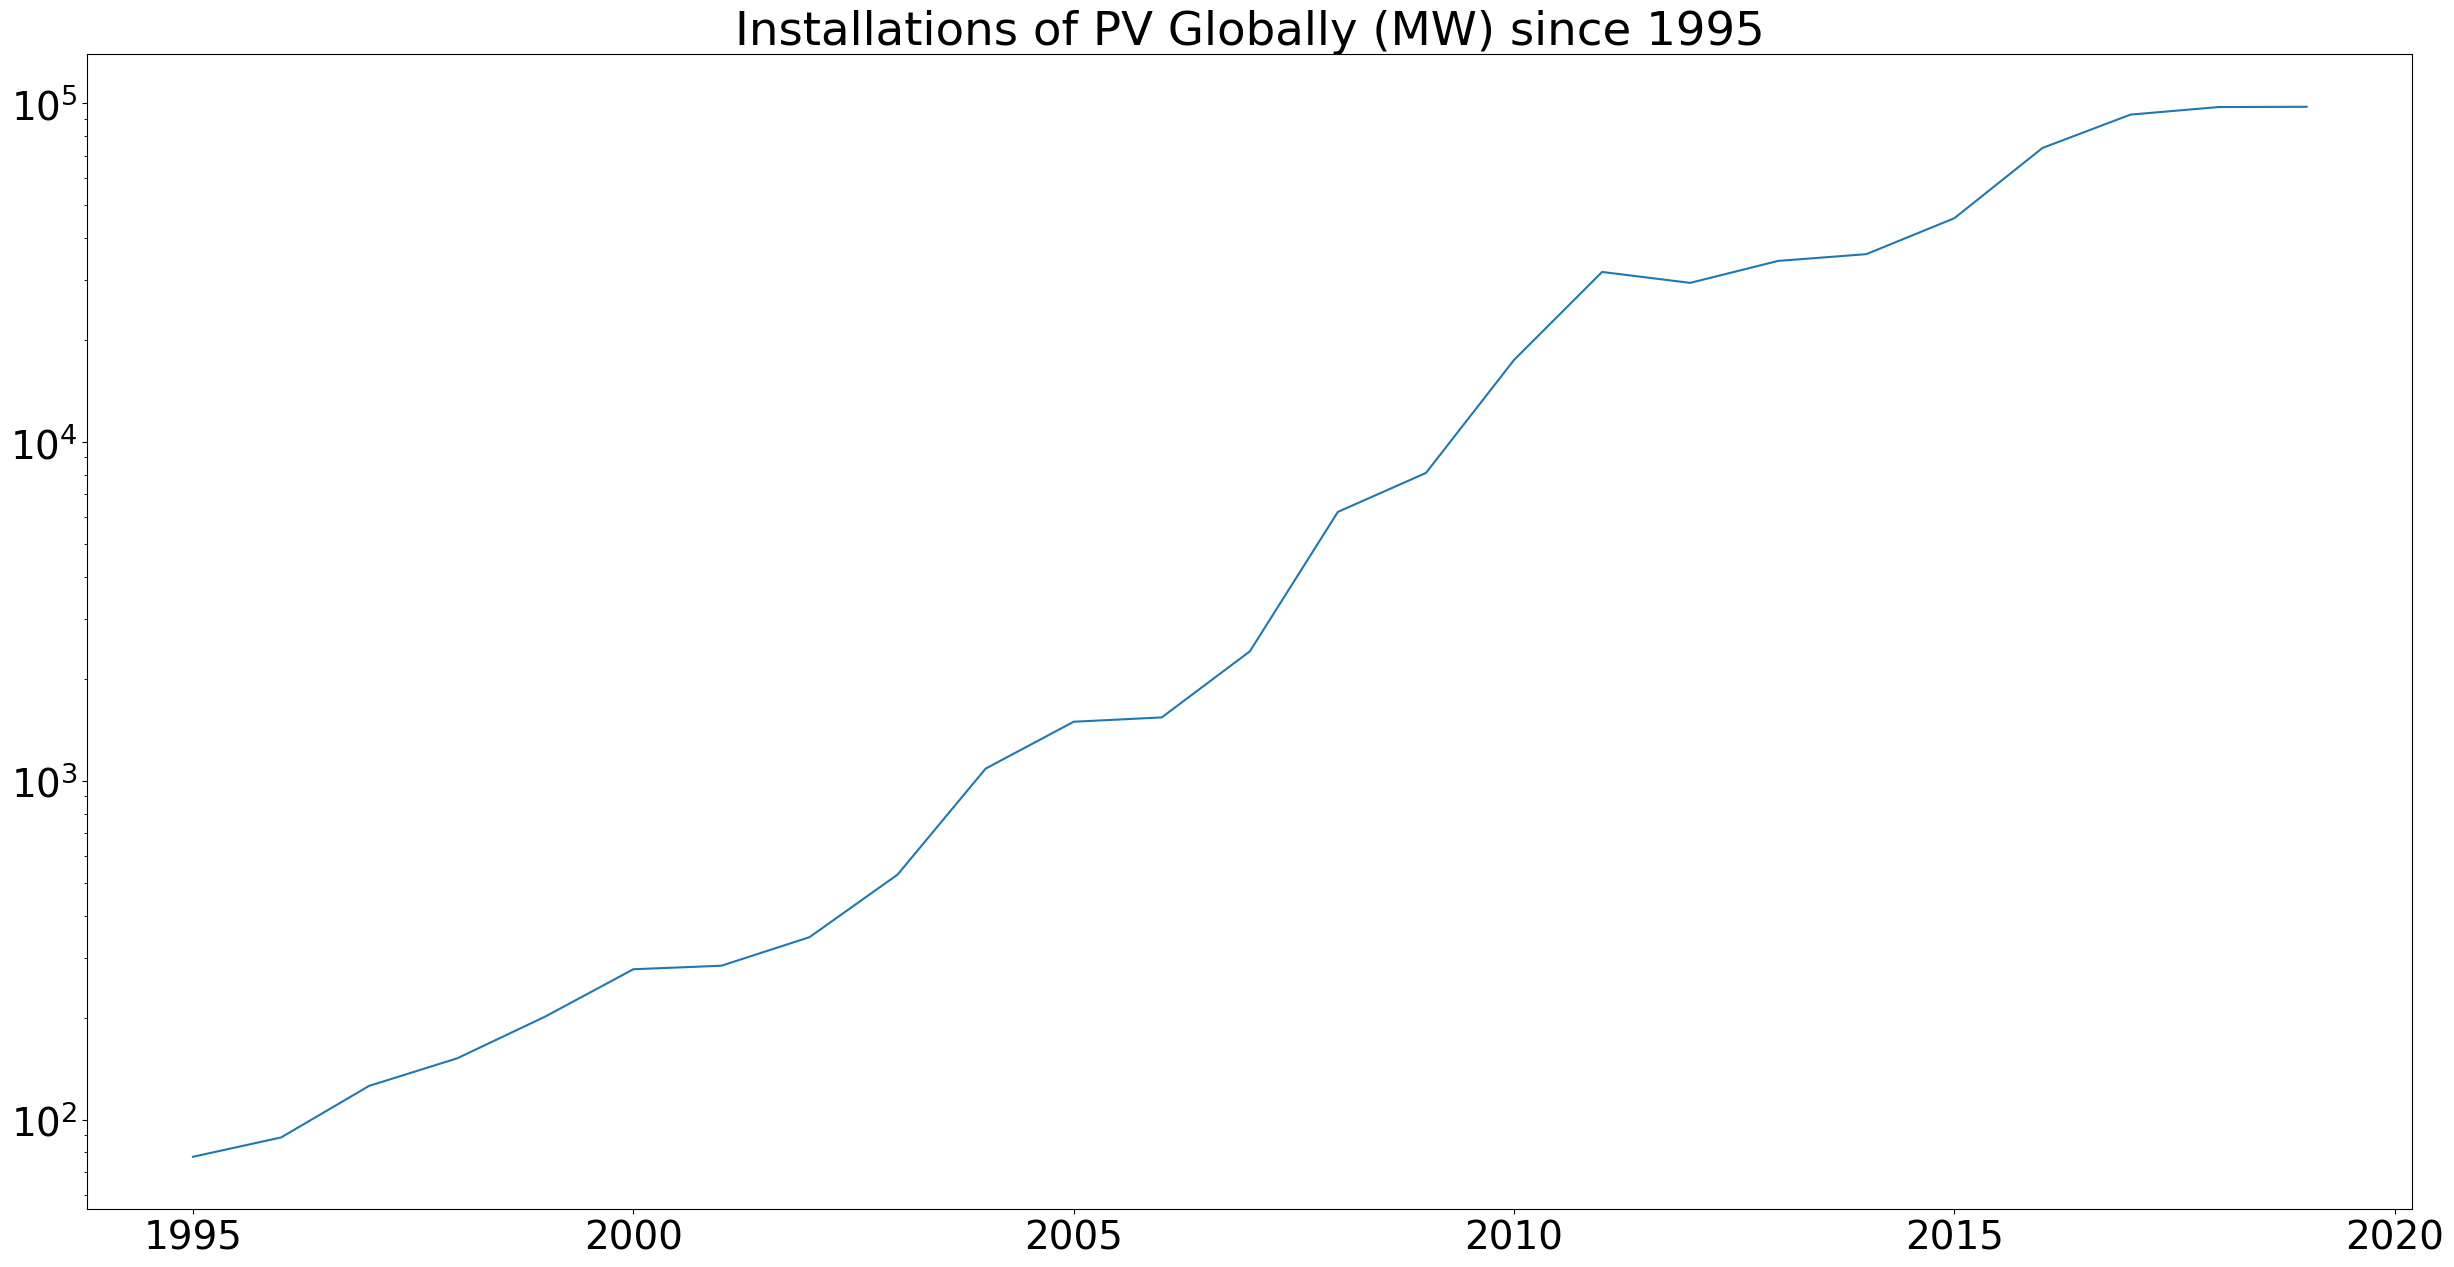

In [6]:
installs = pd.concat([installs_old_Goetz,installs_recent_IRENA])
plt.plot(installs)
plt.yscale('log')
plt.title('Installations of PV Globally (MW) since 1995')

In [7]:
installs.to_csv(os.path.join(supportMatfolder, 'output_Global_allPV_installs.csv'))

# Marketshare weight the installation data for percent of Silicon vs Thin Film

In addition to compiling a single installation record for 1995 through the present, this data is total cumulative, but the tool it currently considering crystalline silicon technology only (i.e. mono and multi, but not ribbon or amorphous).

In [8]:
cwd = os.getcwd() #grabs current working directory
df_raw_mrktshr_siVtf = pd.read_csv(os.path.join(supportMatfolder,'MarketShare_global_c-SiVSthinfilm.csv'), index_col='Year')
refs = df_raw_mrktshr_siVtf.columns
print(len(refs))

4


(50.0, 100.0)

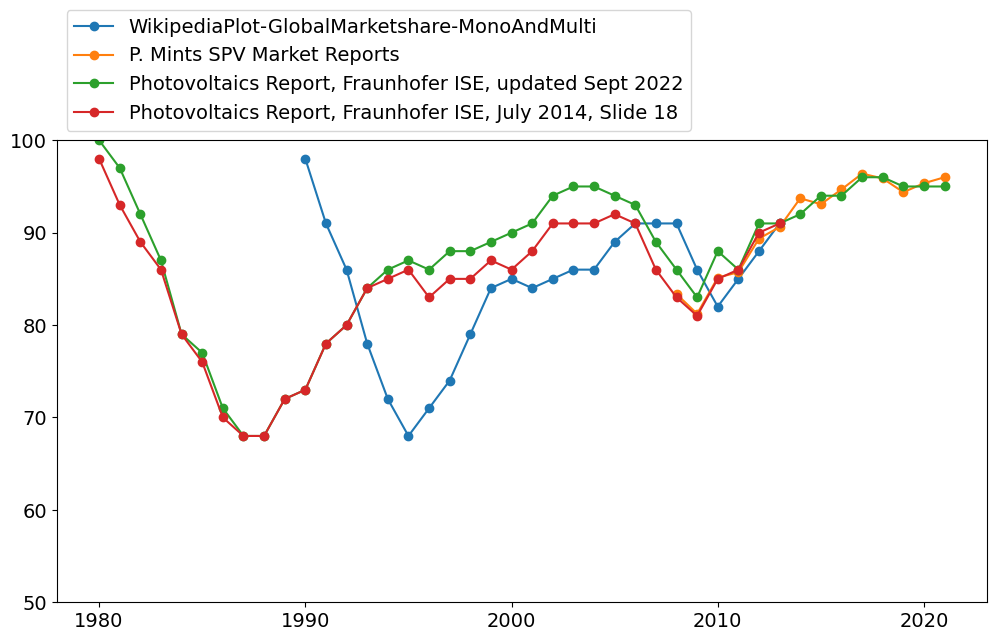

In [9]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[0]],marker='o',label=refs[0])
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[1]],marker='o',label=refs[1])
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[2]],marker='o',label=refs[2])
plt.plot(df_raw_mrktshr_siVtf.index,df_raw_mrktshr_siVtf[refs[3]],marker='o',label=refs[3])
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left")
plt.ylim(50,100)

The 2020 Fraunhofer and 2014 Fraunhofer appear to agree reasonably closely, and Mints agrees closely for the amount of time there is overlap. The unknown sourced wikipedia figure doesn't agree until 2010, but given the unknown source, it will be discarded. We will use the Fraunhofer ISE 2020 market share data for the entire time period.

In [10]:
refs

Index(['WikipediaPlot-GlobalMarketshare-MonoAndMulti',
       'P. Mints SPV Market Reports',
       'Photovoltaics Report, Fraunhofer ISE, updated Sept 2022',
       'Photovoltaics Report, Fraunhofer ISE, July 2014, Slide 18'],
      dtype='object')

In [11]:
df_mrktshr_global =  pd.DataFrame(df_raw_mrktshr_siVtf[refs[2]]) #select Fraunhofer for historical 1995-2020
mrktshr_global = df_mrktshr_global.loc[(df_mrktshr_global.index>=1995)]
# use PMints for most recent data
mrktshr_global.columns = ['Global_MarketShare']
#print(mrktshr_global)

(0.0, 1.1)

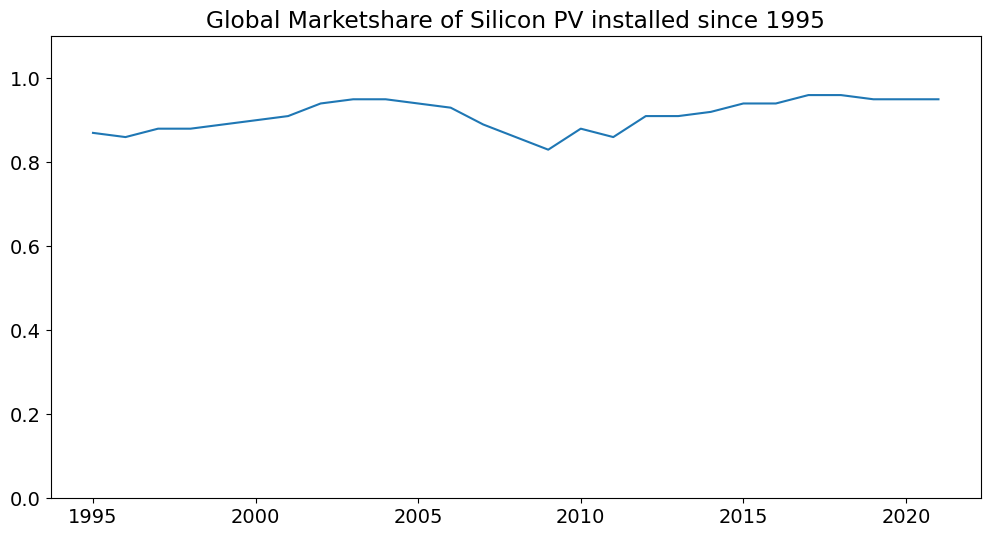

In [12]:
#convert to decimal
mrktshr_global_pct = mrktshr_global/100

plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(mrktshr_global_pct)
plt.title('Global Marketshare of Silicon PV installed since 1995')
plt.ylim(0,1.1)

# Marketshare weight PV installs by percent Silicon
Now we have a marketshare percentage of silicon for 1995 through 2019. We will multiply the PV installs by this silicon marketshare to get the MW of silicon PV installed globally since 1995.

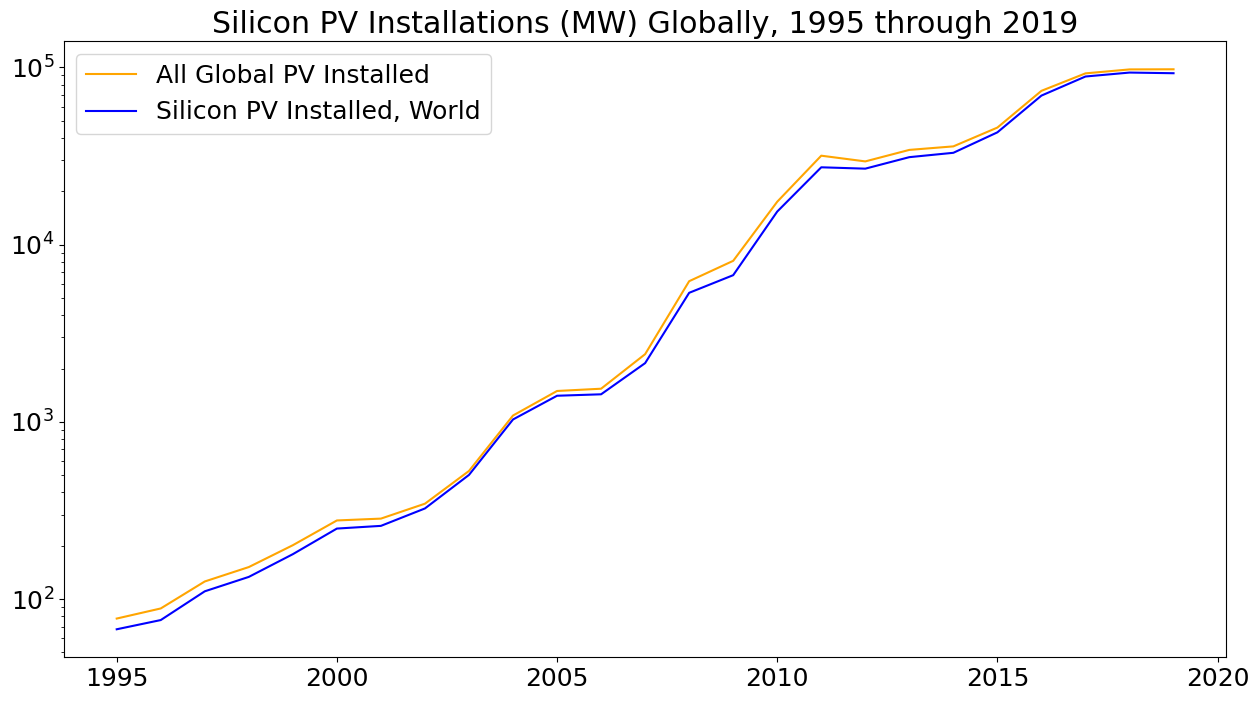

In [13]:
#put the two dataframes together, joining for available data (excludes NANs)
dfs = [installs,mrktshr_global_pct]
df = pd.concat(dfs, axis=1, join='inner')
df_clean = df.dropna()
#creates the marketshare weighted c-Si install data
world_si_installs = df_clean.agg('prod', axis='columns') 

#print(us_si_installs)
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (15, 8)
plt.plot(installs, label='All Global PV Installed', color='orange')
plt.plot(world_si_installs, label='Silicon PV Installed, World', color='blue')
plt.yscale('log')
plt.title('Silicon PV Installations (MW) Globally, 1995 through 2019')
plt.legend()

In [14]:
cwd = os.getcwd() #grabs current working directory
cwd

'C:\\Users\\hmirletz\\Documents\\GitHub\\PV_ICE\\docs\\tutorials\\baseline development documentation'

In [15]:
#world_si_installs.to_csv(cwd+'/../../PV_ICE/baselines/SupportingMaterial/output_Global_SiPV_installs.csv', index=True)
world_si_installs.to_csv(os.path.join(supportMatfolder, 'output_Global_allPV_installs.csv'))


This data only takes installs through 2019. For the remaining years through 2050, a compound annual growth rate of 8.9% was used to predict increasing installations. This compound annual growth rate was sourced from IRENA 2016 EoL Mangement Report and IRENA 2019 Future of PV Report.

# Global Installations by Country

This section documents and munges the IRENA world historical PV install data by country. We can then modify it by the world marketshare of silicon.

In [16]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt
cwd = os.getcwd() #grabs current working directory

supportMatfolder = str(Path().resolve().parent.parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')


In [17]:
IRENA_raw_file = os.path.join(supportMatfolder, 'HistoricalCapacityWorld-QueryResult-PVCumCap.xlsx') #THIS IS CUMULATIVE
IRENA_global_raw = pd.read_excel(IRENA_raw_file, header=7, index_col=0) #set Country/area as index
#remove the flag indicator columns or any unnamed
IRENA_global_raw.drop(columns=list(IRENA_global_raw.filter(like='Unnamed')), inplace=True) 
IRENA_global_raw.drop(columns=['Technology','Indicator'], inplace=True) #drop these columns

In [18]:
IRENA_locs = list(IRENA_global_raw.index)
regions = ['Africa','Asia','C America + Carib','Eurasia','Europe','EU 27','Middle East','N America','Oceania','S America']
countries = [i for i in IRENA_locs if i not in regions] #leaves in world

In [19]:
IRENA_global = IRENA_global_raw.T

In [20]:
shiftpos = IRENA_global.shift(1).fillna(0)

In [21]:
IRENA_global_annual = IRENA_global-shiftpos

In [22]:
IRENA_regions = IRENA_global_annual.loc[:,regions]
IRENA_countries = IRENA_global_annual.loc[:,countries]

In [23]:
IRENA_regions.to_csv(path_or_buf=os.path.join(supportMatfolder, 'output-RegionInstalls-alltech.csv'))
IRENA_countries.to_csv(path_or_buf=os.path.join(supportMatfolder, 'output-CountryInstalls-alltech.csv'))

## Market Share Weight Global installs by Silicon

In [24]:
mrktshr_global.index[-1] #what is the last year we have data for?

2021

In [25]:
#trim the c-Si marketshare to match index of IRENA installs
mrktshr_cSiglobal_IRENA = mrktshr_global.loc[mrktshr_global.index>1999]/100 #turn into decimal

In [26]:
mrktshr_cSiglobal_IRENA.columns

Index(['Global_MarketShare'], dtype='object')

In [27]:
IRENA_regions_cSi = IRENA_regions.multiply(mrktshr_cSiglobal_IRENA["Global_MarketShare"], axis="index")
IRENA_countries_cSi = IRENA_countries.multiply(mrktshr_cSiglobal_IRENA["Global_MarketShare"], axis="index")

In [28]:
IRENA_regions_cSi.to_csv(path_or_buf=os.path.join(supportMatfolder, 'output-RegionInstalls-cSi.csv'))
IRENA_countries_cSi.to_csv(path_or_buf=os.path.join(supportMatfolder, 'output-CountryInstalls-cSi.csv'))

In [29]:
#access the global historical install and create projection
IRENA_hist_cSi = pd.read_csv(os.path.join(supportMatfolder,'output-CountryInstalls-cSi.csv'), index_col=0)

In [30]:
IRENA_hist_cSi_world = pd.DataFrame(IRENA_hist_cSi['World']) #extract just the global historical installs (this is a series)

In [31]:
#create a full historical deployment + projection 
# 2050 needs cumulative of 14,036 GW of PV globally [World Energy Transitions Outlook: 1.5°C Pathway.IRENA; 2021]
#https://irena.org/Statistics/View-Data-by-Topic/Energy-Transition/REmap-Energy-Generation-and-Capacity
idx = pd.RangeIndex(start=2018,stop=2051,step=1) #create the index
IRENA_world_cSi_project = pd.DataFrame(index=idx, columns=['World_cum'], dtype=float) #turn into df and add column to match other series
IRENA_world_cSi_project.loc[2018]=481*1000 #MW in 2018
IRENA_world_cSi_project.loc[2050]=14036*1000 #MW in 2050

14044653.477363031


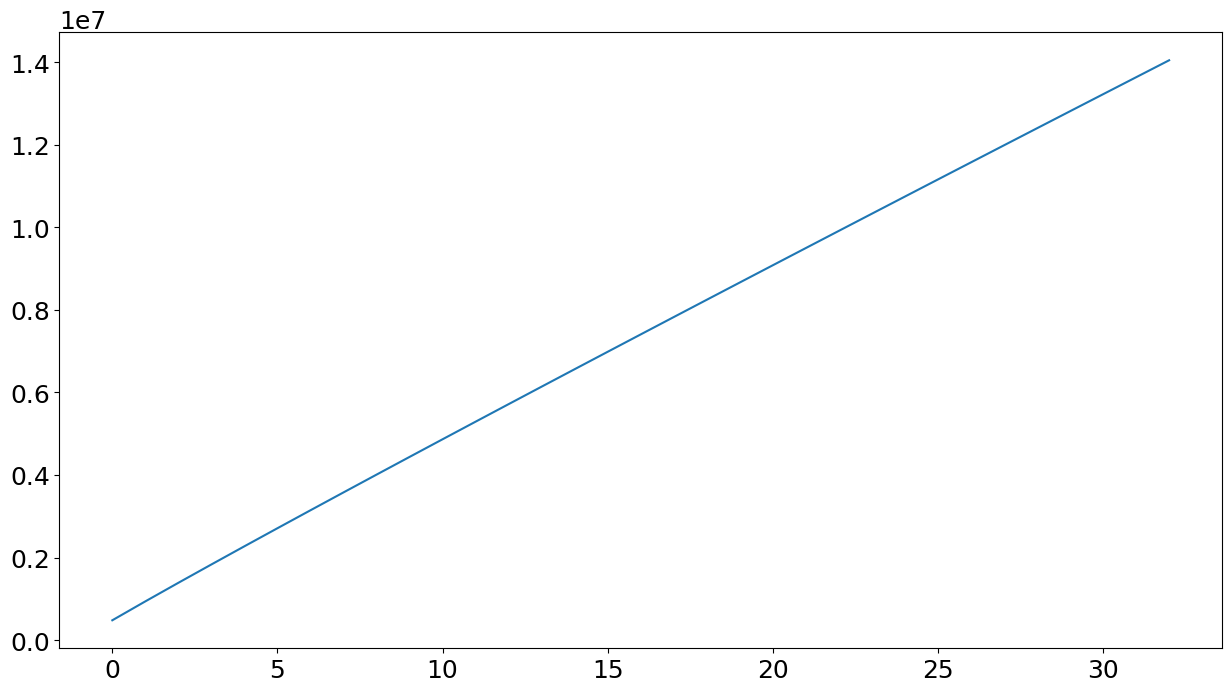

In [32]:
# exponential interpolation option - not great
# Import curve fitting package from scipy
from scipy.optimize import curve_fit
# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)
#generae a dataset for the area in between
y_dummy = power_law(IRENA_world_cSi_project.index-2017, IRENA_world_cSi_project['World_cum'][2018], 0.965)
#played around with the exponential until y_dummy[31] closely matched 14036 GW.
print(y_dummy[32])
plt.plot(y_dummy)
#plt.plot(IRENA_world_cSi_project['World_cum'][2050], marker='o')

In [33]:
IRENA_world_cSi_project['World_cum_fill']=y_dummy
IRENA_world_cSi_project.loc[2050]

World_cum         1.403600e+07
World_cum_fill    1.404465e+07
Name: 2050, dtype: float64

In [34]:
#IRENA_world_cSi_project.interpolate(inplace=True) #create the cumulative global deployed pv each year (linear also not great)
IRENA_world_cSi_project['World'] = IRENA_world_cSi_project['World_cum_fill']-IRENA_world_cSi_project['World_cum_fill'].shift(1).fillna(0)

In [35]:
IRENA_world_cSi_project_annual_torev = IRENA_world_cSi_project.loc[2022:2050,['World']]
IRENA_world_cSi_project_annual = IRENA_world_cSi_project_annual_torev.iloc[::-1] #reverse the exponential to be more realistic
IRENA_world_cSi_project_annual.index = IRENA_world_cSi_project_annual_torev.index #reset index related to above

In [36]:
IRENA_cSi_world = pd.concat([IRENA_hist_cSi_world,IRENA_world_cSi_project_annual])
#IRENA_cSi_world

Text(0, 0.5, 'Annually Deployed PV [MWdc]')

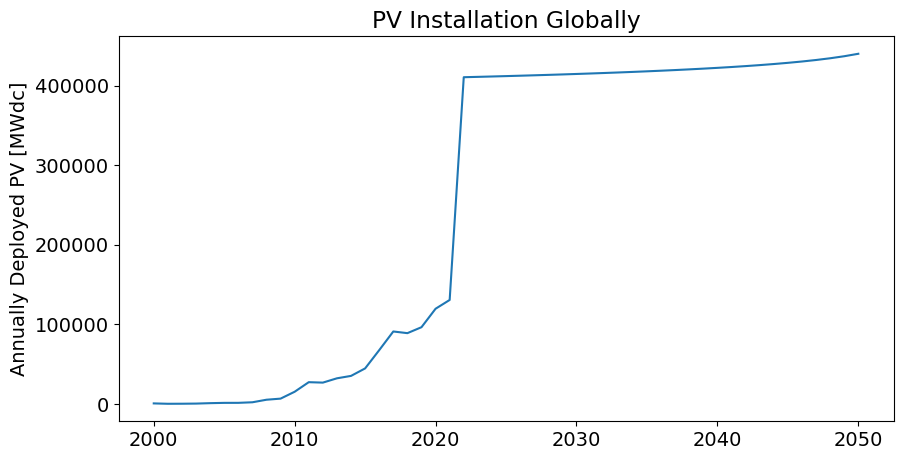

In [37]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (10, 5)
plt.plot(IRENA_cSi_world)
plt.title('PV Installation Globally')
plt.ylabel('Annually Deployed PV [MWdc]')

# Alternate Future Projection Through 2050
The above curve looks ridiculous, so lets make something else literature based. Literature values for through 2050 include:
- Haegel et al 2019
    - 2030: 10 TW, cumulative
    - 2050: 30-70 TW, cumulative
- DNV GL Energy Transition Outlook 2022
    - 2030: 364 GW, annual
    - 2040: 650 GW, annual (approx)
    - 2050: 780 GW, annual (approx)
    - 2050: 14.5 TW, cumulative
- IEA/IRENA Net Zero by 2050
    - 2030: 4.956 TW, cumulative
    - 2050: 14.5 TW, cumulative
    - 600 GW, annual
- BNEF New Energy Outlook 2021, Green Scenario
    - through 2030: 455 GW, annual
    - through 2050: 710 GW, annual
- ITRPV 2022, Summary of Scenarios
    - Broad Electrification, 2050: 63.4 TW cumulative, 4.5 TW annual
    - Electricity Scenario, 2050: 22.0 TW cumulative, 1.4 TW annual
    
So lets say cumulative of 50 TW in 2050.

In [38]:
#2021:
cumPV_2021 = IRENA_global.loc[2021,'World']
print('In 2021, there is a cumulative of '+str(round(cumPV_2021,2))+' MWdc installed globally.')

In 2021, there is a cumulative of 848404.55 MWdc installed globally.


In [39]:
cumPV2050_MWdc = 50*1000000 #MW or 50 TW
req_additions = cumPV2050_MWdc-cumPV_2021
print('A total of '+str(round(req_additions,0))+' MWdc need to be added between 2022 and 2050')

A total of 49151595.0 MWdc need to be added between 2022 and 2050


In [40]:
req_additions/(2050-2022)

1755414.1232635267

In [64]:
idx_fullrange = pd.RangeIndex(start=2000,stop=2051,step=1) #create the index
altproj_50TW_cum = pd.DataFrame(index=idx_fullrange, columns=['World_cum'], dtype=float) #turn into df 

altproj_50TW_cum.loc[2000:2022] = IRENA_global[['World']] #assign historical cumulative 
altproj_50TW_cum.loc[2050] = cumPV2050_MWdc #create 50 TW cumulative in 2050
altproj_50TW_cum.interpolate(method='quadratic', inplace=True) #interpolate using a quadratic fit (cubic also looked good)

#create the annual installs from the cumulative
altproj_50TW_cum_shift = altproj_50TW_cum.shift(1).fillna(0)
altproj_50TW_cum['World_annual_[MWdc]'] = altproj_50TW_cum-altproj_50TW_cum_shift

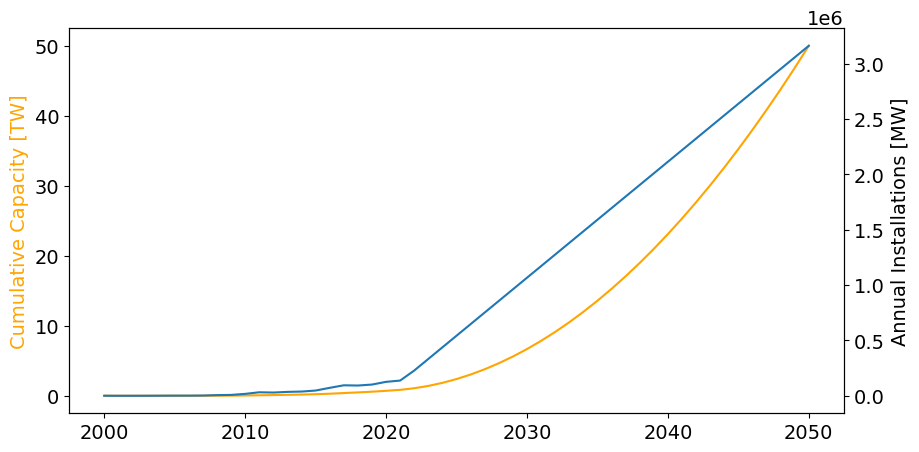

In [78]:
fig, ax1 = plt.subplots()

ax1.plot(altproj_50TW_cum['World_cum']/1e6, color='orange')
ax1.set_ylabel('Cumulative Capacity [TW]', color='orange')
ax2 = ax1.twinx()
ax2.plot(altproj_50TW_cum['World_annual_[MWdc]'])
ax2.set_ylabel('Annual Installations [MW]')

plt.show()

In [80]:
altproj_50TW_annual_TW = altproj_50TW_cum['World_annual_[MWdc]']/1e6
#compare to 
#2030: 364 GW, annual
#2040: 650 GW, annual (approx)
#2050: 780 GW, annual (approx)
altproj_50TW_annual_TW.loc[2030]
altproj_50TW_annual_TW.loc[2040]
altproj_50TW_annual_TW.loc[2050]

3.1613296584954114

In [82]:
altproj_50TW_cum.loc[2030,'World_cum']/1e6

6.675188314199504

This projection is higher than DNV GL annual deployments because it achieves a cumulative of 50 TW in 2050, as opposed to 14.7 TW. Similarly, it has a higher deployment rate than BNEF. The ITRPV scenarios range from a cumulative of 22 and 63 TW in 2050, thus our scenario would fall in the middle - we see that the annual deployment in 2050 is indeed between ITRPVs 1.4 TW and 4.5 TW annual deployment. In 2030, this projection achieves 6.6 TW of cumulative deployment, which falls between Haegel et al's 10 TW and IRENA's Net Zero 4.9 TW. 

There is also a smooth transitition of increasing deployments, as opposed to a step change.

In [76]:
altproj_50TW_cum.to_csv(os.path.join(supportMatfolder,'output-installationProjection-World-50TW.csv'))

## Projection through 2100
We can assume a few options when projecting through 2100:
- maintain capacity, no new growth only replacements
- small amount of growth, possibly based on historical average increasing energy demands

**For Small growth through 2100:**
From Haegel et al, there are historical increasing energy demands 2000 through 2050, derived from the World Energy Outlook
the slopes of these lines are 0.624 for increasing electricity demand and 1.532 for increasing energy consumption (see LiteratureIntallationProjections.xlsx in SupportingMaterials folder). If we assume broad electrification, we would need to use the energy consumption slope. If we assume that PV maintains a constant marketshare of that energy supply, then we can apply the energy demand slope to 2050 through 2100 as a steady increase in PV installation starting at the 50 TW in 2050.

In [94]:
#y=1.532t + 50 #TW
idx_late = pd.RangeIndex(start=2050,stop=2101,step=1) #create the index
proj_2050_2100_energyIncrease = pd.DataFrame(index=idx_late, columns=['World_cum'], dtype=float) #turn into df 
proj_2050_2100_energyIncrease.loc[2050,'World_cum'] = 50*1e6 #set 2050

#create a annual additions df
added = pd.DataFrame(index = pd.RangeIndex(start=0, stop=51, step=1), dtype=float)
added['World_annual[MWdc]'] = 1.532*(proj_2050_2100_energyIncrease.index[t]-2050) #incremental increase every year

#create cumulative


IndexError: index 2050 is out of bounds for axis 0 with size 51

In [91]:
proj_2050_2100_energyIncrease.index[0]-2050

0

## Country wise

In [ ]:
#create deployment profile 2000 through 2100
#pull in processed file from ""(baseline dev) PV Installations - Global" journal
#these are annual additions in MWdc
histinstalls_country_alltech = pd.read_csv(os.path.join(supportMatfolder, 'output-CountryInstalls-alltech.csv'), index_col=[0])
#fix Nan to 0.0
histinstalls_country_alltech = histinstalls_country_alltech.fillna(0.0)
histinstalls_country_alltech.tail()